<a href="https://colab.research.google.com/github/johncoogan53/XAI_HW2/blob/main/XAI_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 02

Description:

John Coogan

### Data Import

The data is from a Kaggle competition involving Telco customer churn data: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
)

from pygam import LogisticGAM, s, f
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Check for cleanliness

In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From info and describe this data appears to be very clean (which is to be expected from a kaggle dataset)

We will also ensure every variable is of the same type. This dataset is comprised of mostly categorical variables which are binary with an 'other' third category. There are also a few numeric variables as well.

In [6]:
# convert TotalCharges to numeric, if fails, set to NaN
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["StreamingTV"].unique()

# treating churn as a continuous variable
data["Churn"] = pd.to_numeric(
    data["Churn"].str.replace("Yes", "1").str.replace("No", "0")
)

# Convert gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService,
# OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract,
# PaperlessBilling, PaymentMethod, Churn to category
categorical_columns = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

data[categorical_columns] = data[categorical_columns].astype("category")

## Linear Regression Modeling

In this section we will treat the churn variable as continuous and build a linear model that will help to predict the churn of a customer. We will break this down into sub-sections to make it easier to follow.

* 1. Evaluating linear regression assumptions
* 2. Building a linear regression model (iterative)
* 3. Evaluating the model

Assumptions of Linear Regression:

1. Linearity: The relationship between the independent and dependent variables is linear.
2. Independence: Observations are independent of each other.
3. Homoscedasticity: The residuals have constant variance at every level of the independent variables.
4. Normality: The residuals are normally distributed.

How to evaluate these assumptions:
1. Linearity: Use scatter plots to check for linearity.
2. Independence: This is assumed to be true for most datasets.
3. Homoscedasticity: Use residuals vs. fitted values plot.
4. Normality: Use a QQ plot.

### Linearity

>Univariate analysis between our continuous variables and the target variable. Assessing linearity for between our continuous target and categorical variables is not as straightforward so we wills start here.

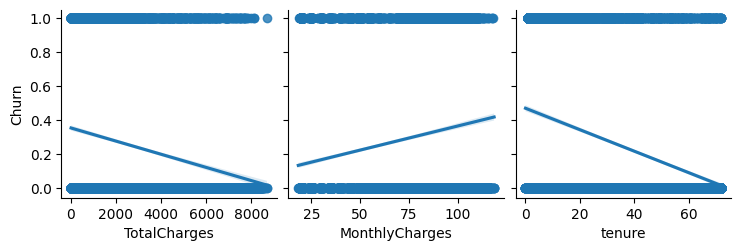

In [7]:
# Suppress warnings because they are distracting
warnings.filterwarnings("ignore")

# Scatter plot for continuous variables
sns.pairplot(
    data,
    x_vars=["TotalCharges", "MonthlyCharges", "tenure"],
    y_vars="Churn",
    kind="reg",
)

plt.show()

>we can see that there is a negative relationship between both total charges and tenure and churn (largely because these are likely to be colinear) and a positive relationship between monthly charges and churn. This does not guarantee linearity (since the reg argurment to pairplot only plots a linear regression line) but it is a good start. Because this data is representative of a real world scenario, we can assume that there will be non-linear trends and we will need to use a more complex model to capture these trends.

### Train Test Split

>We get an error later on when training that there are NaN values. We will check for those here and determine how to proceed.

In [8]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

>We can see that there are 11 NaN values in the total charges column. We will drop these rows and then proceed with the train test split since 11 out of 7043 is a small percentage of the data.

In [9]:
data.dropna(inplace=True)

In [10]:
y = data["Churn"]
X = data.drop(columns=["Churn", "customerID"])
X = pd.get_dummies(X, drop_first=True)

In [11]:
y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

>Of particular note here is the class imbalance in our target. This may make predicting churn difficult.

In [12]:
# we will use a 20% split for the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Scale features

Transform each feature so that it has a mean of 0 and a standard deviation of 1. This is going to allow us to compare coeffients directly and also should help with the convergence of our models.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Baseline Linear Model

In [14]:
# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

y_pred_linear_binary = (y_pred_linear > 0.5).astype(int)
accuracy_linear = accuracy_score(y_test, y_pred_linear_binary)
print(f"Linear Regression Accuracy: {accuracy_linear}")

Linear Regression MSE: 0.14593552097785373
Linear Regression Accuracy: 0.7917555081734187


Difficult to extract the coeffient values so we will use statsmodels for its valuable summary options and ensure we get the same MSE as a validation step

In [15]:
# Statsmodels example
sm_X_train = X_train_scaled_df.copy()
sm_X_train["const"] = 1
sm_X_test = X_test_scaled_df.copy()
sm_X_test["const"] = 1


sm_model = sm.OLS(y_train, sm_X_train).fit()
print(sm_model.summary())
y_pred_sm = sm_model.predict(sm_X_test)
mse_sm = mean_squared_error(y_test, y_pred_sm)
print(f"Statsmodels MSE: {mse_sm}")

y_pred_sm_binary = y_pred_sm > 0.5
accuracy_sm = accuracy_score(y_test, y_pred_sm_binary)
print(f"Statsmodels Accuracy: {accuracy_sm}")

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:11:53   Log-Likelihood:                -2417.5
No. Observations:                5625   AIC:                             4883.
Df Residuals:                    5601   BIC:                             5042.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

We can see that we get the same MSE for the sklearn and statsmodels implementation. We utilized the statsmodels implementation to be able to get summary output what lets us see coefficient estimates.We can see in this linear regression output that negative coefficients correspond to a decreased churn likelihood when compared to the reference level in that category or per unit increase for numerical. Positive coefficients correspond to an increased churn likelihood when compared to the reference level in that category or per unit increase for numerical.

Numeric Example:

Tenure:
- A one unit increase in tenure is associated with a -0.0463 decrease in the expected churn value (since we are viewing churn as a continuous variable)
- This trend is indicated as statistically significant by the p-value of 0.001 (but we don't p-hack or hunt for significant results so we wont focus on p-value)

SeniorCitizen_1:
- Being a senior citizen is associated with a 0.0242 increase in the expected churn value (since we are viewing churn as a continuous variable)
- SeniorCitizen_1 or other variables that have '_No' or other suffixes are to delineate that categorical variable from its reference level. This means all coefficients should be interpreted in comparison to the category not listed (in this instance, not being a senior citizen)

### Verifying Homoscadasticity and Normality

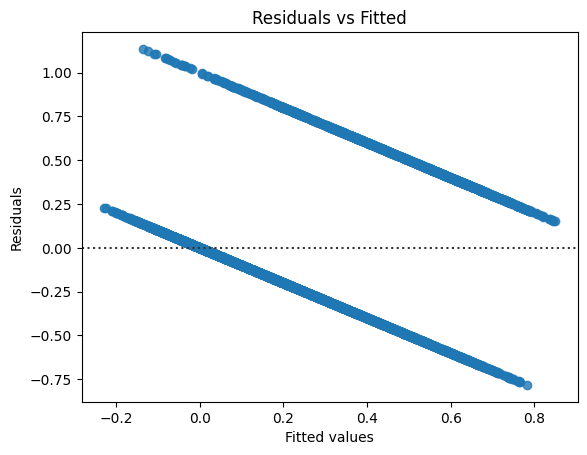

In [16]:
residuals = sm_model.resid
fitted = sm_model.fittedvalues

sns.residplot(x=fitted, y=residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

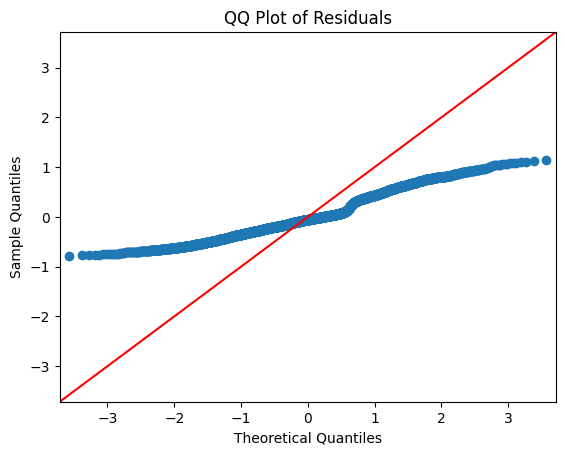

In [17]:
sm.qqplot(residuals, line="45")

plt.title("QQ Plot of Residuals")
plt.show()

We can see that in our residuals vs fitted plot that the expectations for homoscedasticity are not met. We expect to see no identifiable pattern here. We see two defined lines which are indicative of our binary output variable that we are artificially treating as a continuous variable. The fact that there is a line instead of randomly distributed points indicates a non-linear relationship between our features and the target. The QQ plot also indicates that our residuals are not normally distributed. Ultimately we can see that many of the assumptions for linear regression are not met by this data and a more complicated model is necessary. We will first try a LASSO regression to see if we can reduce the features sufficiently to improve our adherence to the assumptions.

In [18]:
# LASSO to check for feature importance
lasso = Lasso(
    alpha=0.01
)  # alpha is the regularization parameter which will determine the strength of the 'shrinkage' for variables
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}")

y_pred_lasso_binary = [1 if i > 0.5 else 0 for i in y_pred_lasso]
print(f"Lasso Accuracy: {accuracy_score(y_test, y_pred_lasso_binary)}")

Lasso MSE: 0.14574994481719242
Lasso Accuracy: 0.7931769722814499


Here we will attempt to generate similar interpretability to what the GAM will provide later. We will do this by printing out the coefficients of the LASSO model ordered by their absolute value to see which features appear to have the strongest relationship with the target.

In [19]:
# Here we are going to extract the LASSO coefficients like we did above with sm.summary()
lasso_coefs = pd.DataFrame(
    lasso.coef_, index=X.columns, columns=["coefs"]
)  # make a coefficient df
lasso_coefs["abs_coefs"] = abs(
    lasso_coefs["coefs"]
)  # add the absolute value for sorting purposses
lasso_coefs = lasso_coefs[
    lasso_coefs["abs_coefs"] > 0
]  # only keep the non-zero coefficients
lasso_coefs = lasso_coefs.sort_values(
    by="abs_coefs", ascending=False
)  # sort the coefficients
print(lasso_coefs)

                                           coefs     abs_coefs
InternetService_Fiber optic         8.082324e-02  8.082324e-02
tenure                             -7.733446e-02  7.733446e-02
TotalCharges                       -4.627850e-02  4.627850e-02
InternetService_No                 -4.464386e-02  4.464386e-02
Contract_One year                  -3.957803e-02  3.957803e-02
PaymentMethod_Electronic check      3.544789e-02  3.544789e-02
Contract_Two year                  -2.458954e-02  2.458954e-02
OnlineSecurity_Yes                 -2.220928e-02  2.220928e-02
TechSupport_Yes                    -2.108204e-02  2.108204e-02
SeniorCitizen_1                     1.681101e-02  1.681101e-02
StreamingMovies_Yes                 1.503369e-02  1.503369e-02
PaperlessBilling_Yes                1.497957e-02  1.497957e-02
StreamingTV_Yes                     1.237892e-02  1.237892e-02
MultipleLines_Yes                   8.026995e-03  8.026995e-03
Dependents_Yes                     -7.234482e-03  7.234

We can see that, according to the LASSO model, whether or not a customer has fiber optic internet is one of the most important features for predicting churn. This could mean that the telecommunication company's fiber offerring is really bad, driving clients to churn. 

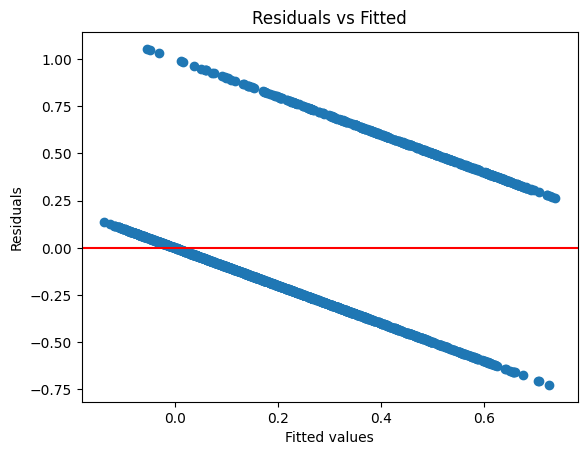

In [20]:
fitted = lasso.predict(X_test_scaled)
residuals = y_test - fitted

plt.scatter(fitted, residuals)
plt.axhline(y=0, color="red", label="0")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

<Figure size 1000x600 with 0 Axes>

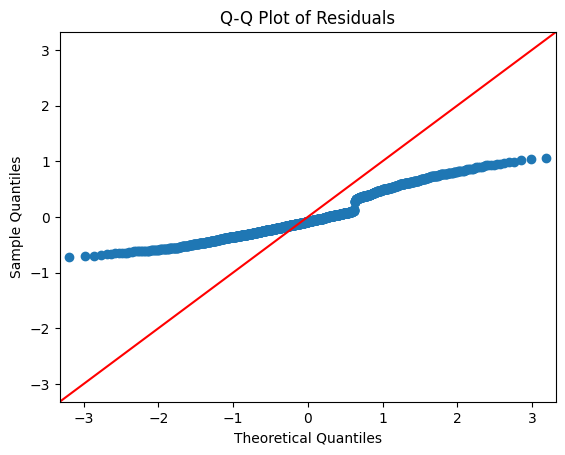

In [21]:
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line="45")
plt.title("Q-Q Plot of Residuals")
plt.show()

We can see in the LASSO output that we achieved an MSE reduction of 0.0002 (which is not a large value but it is a reduction). More importantly, we reduced the number of relevant variables significantly. The table above shows them ranked by feature importance according to the LASSO model. We also see that the residuals vs fitted plot and QQ plot are still not ideal but they are improved. We will now try a more complex model to see if we can improve our adherence to the assumptions of linear regression.

>for simplicity, we will keep these features when we move to Logistic Regression and GAMS

## Logistic Regression Modeling

In [22]:
# reduced X with only the important features
X_train_reduced = X_train_scaled_df[lasso_coefs.index]
X_test_reduced = X_test_scaled_df[lasso_coefs.index]

> We get errors indicating high multicollinearity when we fit a logistic regression to this data. We can look at the variance inflation factors to see which variables are causing this issue.

In [23]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_reduced.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_reduced.values, i)
    for i in range(X_train_reduced.shape[1])
]

print(vif_data)

                               feature       VIF
0          InternetService_Fiber optic  2.185123
1                               tenure  6.631677
2                         TotalCharges  9.054902
3                   InternetService_No       inf
4                    Contract_One year  1.632796
5       PaymentMethod_Electronic check  1.295006
6                    Contract_Two year  2.643673
7                   OnlineSecurity_Yes  1.478102
8                      TechSupport_Yes  1.542840
9                      SeniorCitizen_1  1.136133
10                 StreamingMovies_Yes  1.689895
11                PaperlessBilling_Yes  1.202549
12                     StreamingTV_Yes  1.698069
13                   MultipleLines_Yes  1.381422
14                      Dependents_Yes  1.114476
15     StreamingTV_No internet service       inf
16  OnlineSecurity_No internet service       inf


Here we can see that specific categories from our dummies are highly collinear with others. We will drop the inf VIF columns and then refit the model.

In [24]:
X_train_reduced.drop(
    columns=[
        "InternetService_No",
        "StreamingTV_No internet service",
        "OnlineSecurity_No internet service",
    ],
    inplace=True,
)
X_test_reduced.drop(
    columns=[
        "InternetService_No",
        "StreamingTV_No internet service",
        "OnlineSecurity_No internet service",
    ],
    inplace=True,
)

In [25]:
# Convert y to binary
y_train_binary = y_train.astype("bool")
y_test_binary = y_test.astype("bool")

In [26]:
# Add constant to X_train_reduced and X_test_reduced
sm_X_train_reduced = X_train_reduced.copy()
sm_X_train_reduced["const"] = 1
sm_X_test_reduced = X_test_reduced.copy()
sm_X_test_reduced["const"] = 1

logistic_regression = sm.Logit(y_train_binary, sm_X_train_reduced).fit()
print(logistic_regression.summary())

y_pred_logistic = logistic_regression.predict(sm_X_test_reduced)
y_pred_logistic = y_pred_logistic > 0.5
log_loss_logistic = log_loss(y_test_binary, y_pred_logistic)
print(f"Logistic Log_Loss: {log_loss_logistic}")
accuracy_logistic = accuracy_score(y_test_binary, y_pred_logistic)
print(f"Logistic Accuracy: {accuracy_logistic}")

Optimization terminated successfully.
         Current function value: 0.415962
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5610
Method:                           MLE   Df Model:                           14
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.2816
Time:                        18:11:54   Log-Likelihood:                -2339.8
converged:                       True   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
InternetService_Fiber optic        0.4051      0.049      8.322     

Here we see the same accuracy as our original model but with fewer features. The interpretability of these coefficients suffers significantly however. As an example we see the tenure coefficient is -1.31 which indicates that a one unit increase in tenure is associated with a 0.27 decrease in the log odds of churn. This is a very difficult coefficient to interpret and we will move to a GAM model to help with this.

In [27]:
# sklearn logistic regression just to check against statsmodels
logistic_regression_sklearn = LogisticRegression()
logistic_regression_sklearn.fit(X_train_reduced, y_train_binary)
y_pred_logistic_sklearn = logistic_regression_sklearn.predict(X_test_reduced)

log_loss_logistic_sklearn = log_loss(y_test_binary, y_pred_logistic_sklearn)
print(f"Logistic Log_Loss: {log_loss_logistic_sklearn}")
accuracy_logistic_sklearn = accuracy_score(y_test_binary, y_pred_logistic_sklearn)
print(f"Logistic Accuracy: {accuracy_logistic_sklearn}")

Logistic Log_Loss: 7.531509663397613
Logistic Accuracy: 0.7910447761194029


We see that our statsmodels method does not agree with out sklearn method. The sklearn method appears to be more accurate since the statsmodels method matches the original model identically. We will come back to look at this interesting behavior later.

## GAM Modeling

In [28]:
X_train_reduced.columns

Index(['InternetService_Fiber optic', 'tenure', 'TotalCharges',
       'Contract_One year', 'PaymentMethod_Electronic check',
       'Contract_Two year', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'SeniorCitizen_1', 'StreamingMovies_Yes', 'PaperlessBilling_Yes',
       'StreamingTV_Yes', 'MultipleLines_Yes', 'Dependents_Yes'],
      dtype='object')

In [29]:
gam = LogisticGAM(
    f(0)  # Factor term for 'InternetService_Fiber optic'
    + s(1)  # Smooth term for 'tenure'
    + s(2)  # Smooth term for 'TotalCharges'
    + f(3)  # Factor term for 'Contract_One year'
    + f(4)  # Factor term for 'PaymentMethod_Electronic check'
    + f(5)  # Factor term for 'Contract_Two year'
    + f(6)  # Factor term for 'OnlineSecurity_Yes'
    + f(7)  # Factor term for 'TechSupport_Yes'
    + f(8)  # Factor term for 'SeniorCitizen_1'
    + f(9)  # Factor term for 'StreamingMovies_Yes'
    + f(10)  # Factor term for 'PaperlessBilling_Yes'
    + f(11)  # Factor term for 'StreamingTV_Yes'
    + f(12)  # Factor term for 'MultipleLines_Yes'
    + f(13)  # Factor term for 'Dependents_Yes'
)
gam.fit(X_train_reduced, y_train_binary)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     36.5873
Link Function:                        LogitLink Log Likelihood:                                 -2277.1811
Number of Samples:                         5625 AIC:                                             4627.5369
                                                AICc:                                            4628.0561
                                                UBRE:                                               2.8279
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3008
Feature Function                  Lam

In [30]:
y_pred_gam = gam.predict(X_test_reduced)
gam_accuracy = accuracy_score(y_test_binary, y_pred_gam > 0.5)
print(f"GAM Accuracy: {gam_accuracy}")

GAM Accuracy: 0.7967306325515281


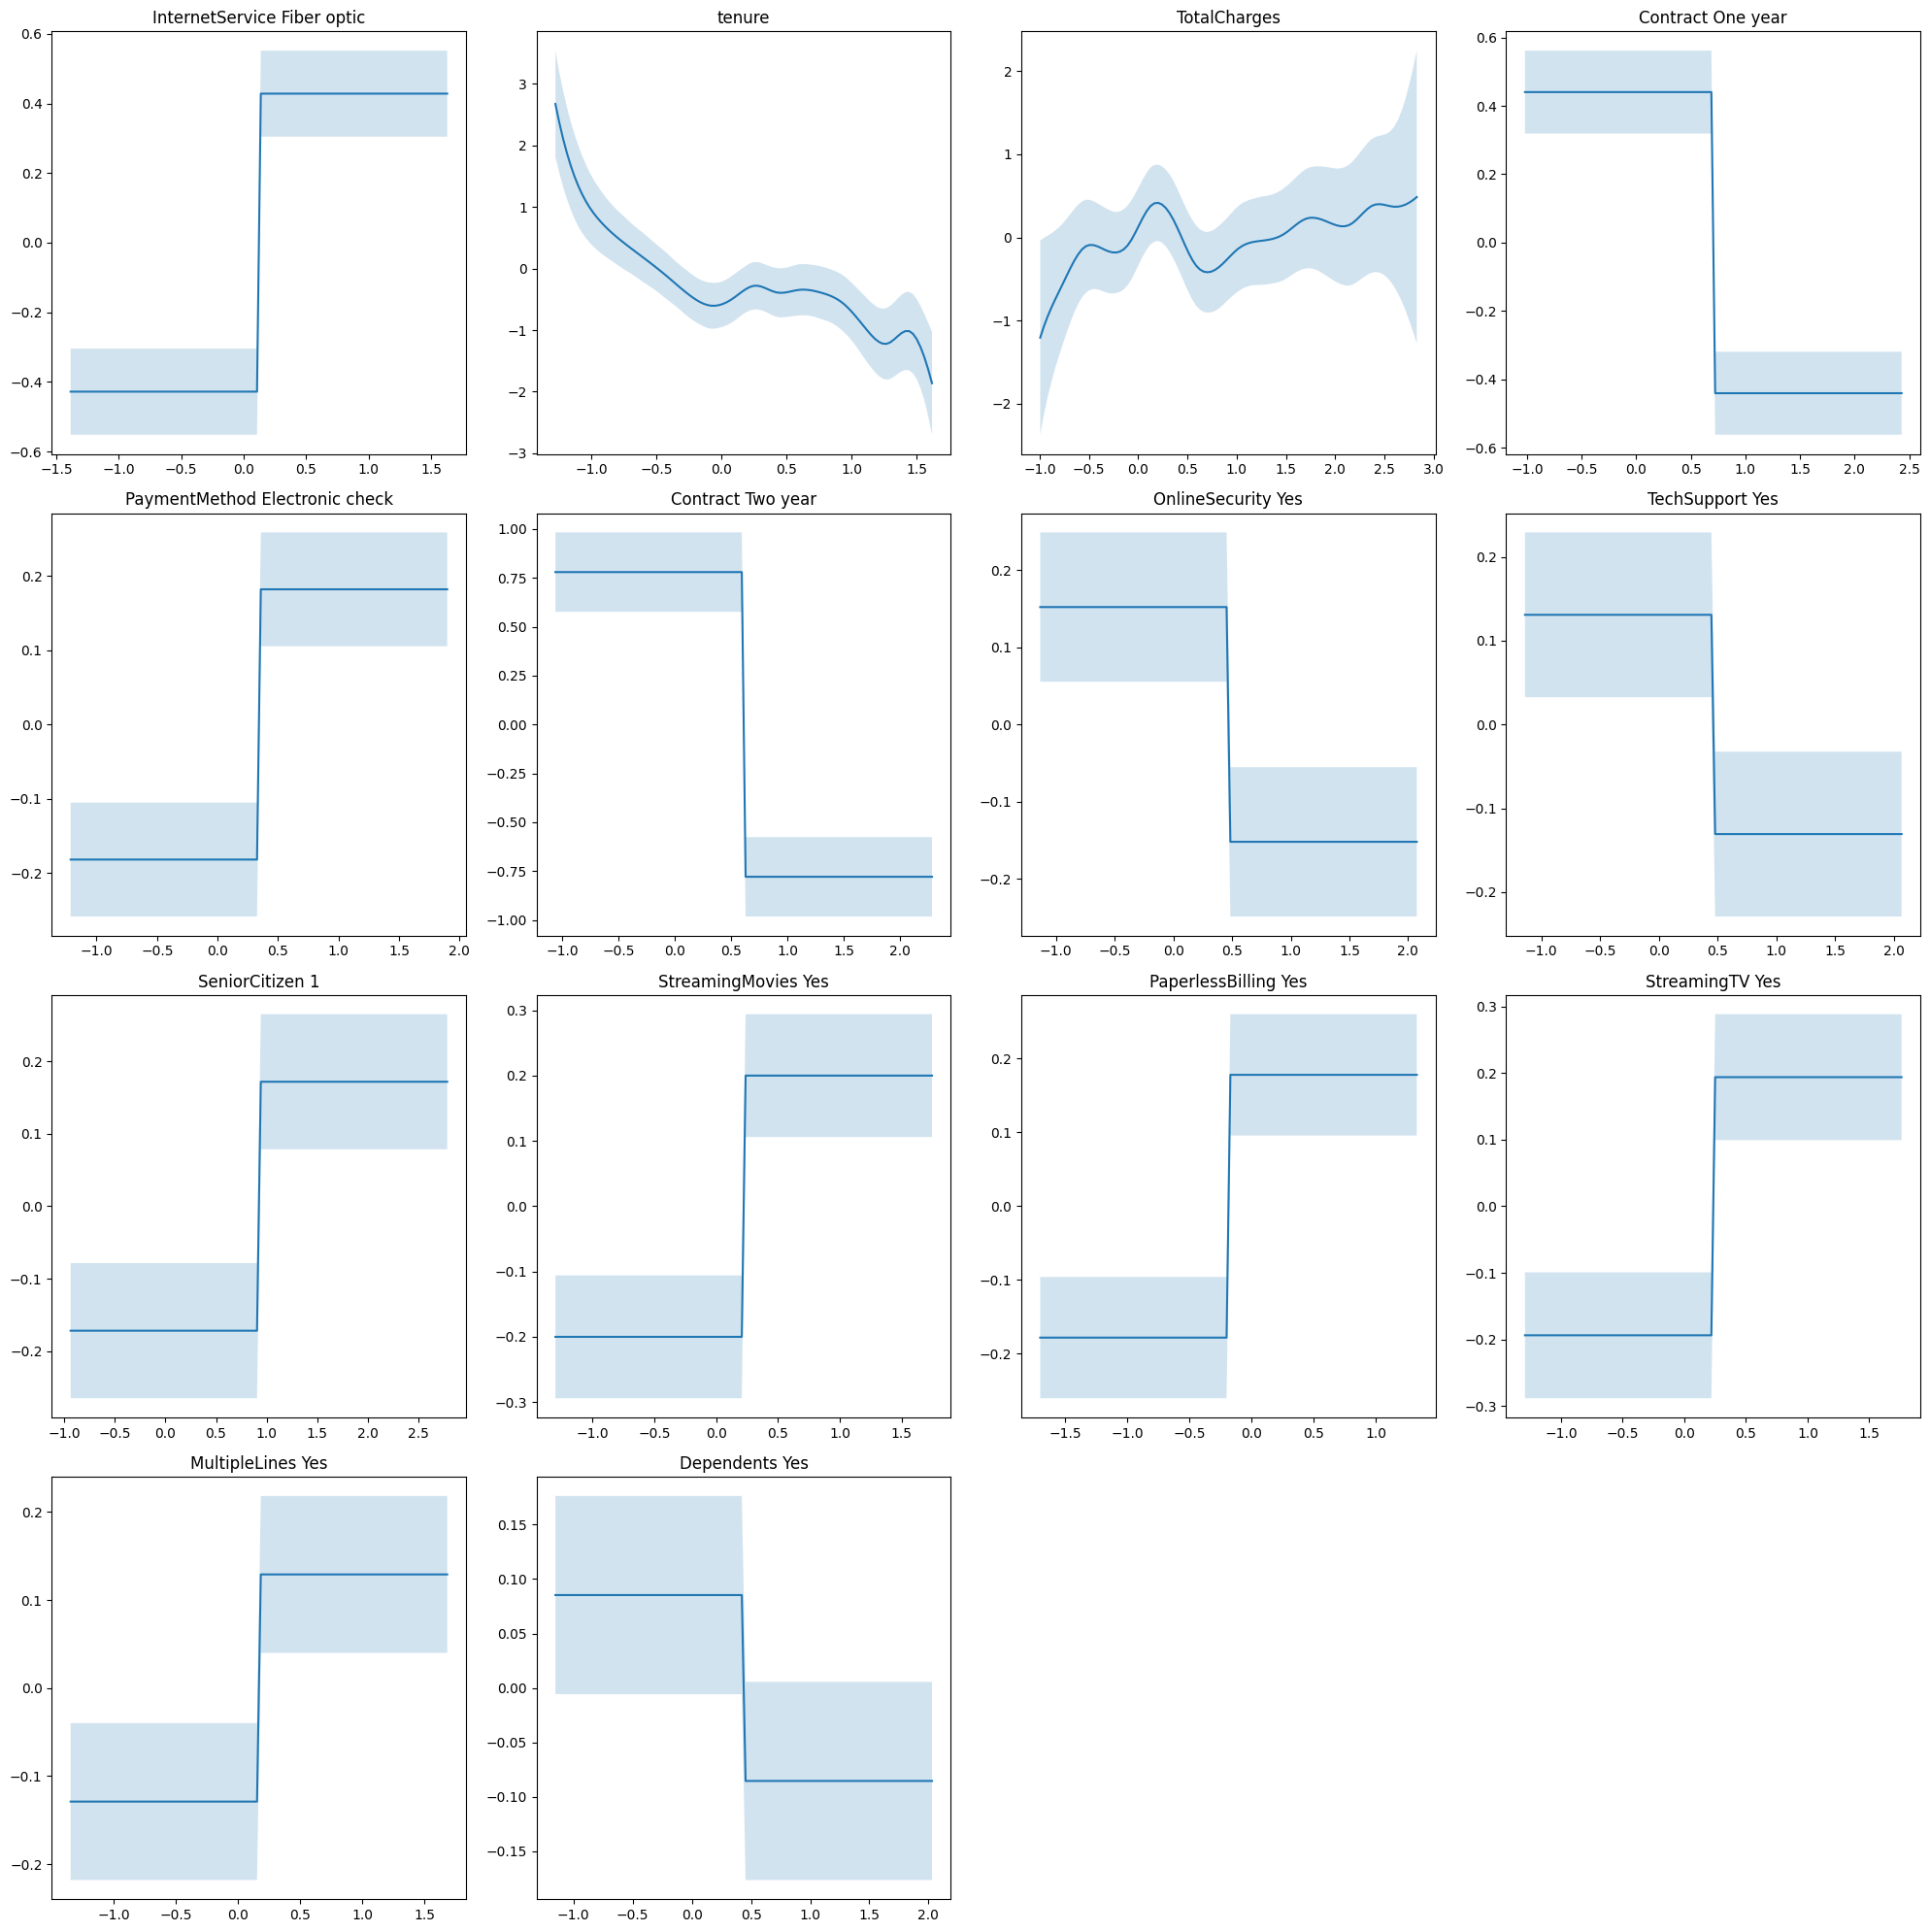

In [31]:
feature_name_dict = {
    0: "InternetService Fiber optic",
    1: "tenure",
    2: "TotalCharges",
    3: "Contract One year",
    4: "PaymentMethod Electronic check",
    5: "Contract Two year",
    6: "OnlineSecurity Yes",
    7: "TechSupport Yes",
    8: "SeniorCitizen 1",
    9: "StreamingMovies Yes",
    10: "PaperlessBilling Yes",
    11: "StreamingTV Yes",
    12: "MultipleLines Yes",
    13: "Dependents Yes",
}

# Plot partial dependence for each feature
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(gam.terms) and not gam.terms[i].isintercept:
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.95)
        ax.plot(XX[:, i], pdep)
        ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
        ax.set_title(f"{feature_name_dict[i]}")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

GAMs can provide us with rich partial dependence output. What we see in the output here is the partial dependence of the churn variable on each feature of our model. The continuous predictors are the squiggly lines showing rough trends. You will notice that all the data is centered on zero because we utilized the standardscalar function to scale the data. To get these partial dependence plots back into the appropriate scale you would need to reverse that operation. But for the large portion of the features you see a step function corresponding to the binary variables. Those step functions which start low and end high indicate that the feature is aligned with churn. Those step functions which start high and end low indicate that the feature is aligned with non-churn (e.g. if you have fiber internet you are more likely to churn).

The tenur variable conforms to our intuition, the longer someone is with the telecom company the less likely they are to churn. This represents either loyal customers or customers who, for one reason or another, have not been dissatisfied enough to leave meaning they likely wont in the future. 

What we can conclude regarding the GAM model are as follows:

- The model outperformed all others, albeit only slightly
- The pseudo R squared value indicates that the model only explains about 30% of the variance in the data
- This leads us to conclude that churn is very difficult to accurately predict (particularly with the given features)
- The GAM outputs a feature importance indicator as well as degrees of freedom indicator that helps us to see how complex the relationships the feature is capturing as well as how important a given feature is in the final prediction. This makes the GAM model user friendly and interpretable particularly when compared to the logistic regression model.

I believe the telecomunications company should use GAMs because they provide the best performance while also making it quite clear which variables are most important for the models prediction. This is important because it shows the company where to apply resources. I will caveat this recommendation by saying that the real take away from this analysis is that there are clearly features influencing churn that the company does not collect yet and so, to get a really accurate model, they may want to do more research into viable factors influencing churn.